# 1. Importing the Libraries

In [2]:
import qutip
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from scipy.fft import *
import numpy.linalg as nplin
from mpl_toolkits import mplot3d


# 2.  Building the Functions

## a. The coefficients for the time-periodical Hamiltonian operator

In [3]:
def coef_z(t, args):
    c_coeff_arr = args['c_coeff']
    omega = args['omega']
    N_max = args['Nmax']
    tsize = args['tsize']
    qJ = args['qJ']
    freq = args['freq']
    
    c_result = np.sum(c_coeff_arr*np.exp((2*np.pi*1j*freq*t)))*1/tsize
        
    return qJ*c_result
  
    
def coef_x(t, args): # This is the oscillating field term
    
    omega = args['omega'] 
    Bx = args['Bx']

    return Bx*np.cos(omega*t)

## b. Finding the magnetization expectation values for each direction (x, y, and z)

In [4]:
def mz_expect(f_modes_table_t, tlist):
    mz_time = []
    for i in range(len(tlist)):
        a = f_modes_table_t[i][0][0]
        b = f_modes_table_t[i][0][1]
        mz_temp = (a.conj()*a-b.conj()*b)[0][0].real
        mz_time.append(mz_temp)
        
    return mz_time


def mx_expect(f_modes_table_t, tlist):
    mx_time = []
    for i in range(len(tlist)):
        a = f_modes_table_t[i][0][0]
        b = f_modes_table_t[i][0][1]
        mx_temp = (a.conj()*b+b.conj()*a)[0][0].real
        mx_time.append(mx_temp)
        
    return mx_time


def my_expect(f_modes_table_t, tlist):
    my_time = []
    for i in range(len(tlist)):
        a = f_modes_table_t[i][0][0]
        b = f_modes_table_t[i][0][1]
        my_temp = (a.conj()*-1j*b+b.conj()*1j*a)[0][0].real
        my_time.append(my_temp)
        
    return my_time


def energy_expect(f_modes_table_t, mz_expect, qJ, omega, Bx, tlist):
    
    energy_time=[]
    for i in range(len(tlist)):
        hamiltonian_matrix = np.array([[qJ*mz_expect[i], Bx*np.cos(omega*tlist[i])],
                                       [Bx*np.cos(omega*tlist[i]), -qJ*mz_expect[i]]])
        
        a = f_modes_table_t[i][0][0] 
        b = f_modes_table_t[i][0][1]
        vector = np.array([a[0][0], b[0][0]])
        first_mul = hamiltonian_matrix @ vector
        second_mul = np.matmul(np.conjugate(vector),first_mul)
        energy_time.append(second_mul)
    
    return energy_time 


## c. Constructing the initial guess of the z-axis magnetization DFT coefficient

In [5]:
def mz_time(c_coeff, time, N_max, omega):

  mz_arr = []

  c_coeff = c_coeff.flatten(order='C')

  for t in time:
    result = 0
    for i in range(len(c_coeff)):
        
      result += c_coeff[i]*np.exp(complex(0, omega*(N_max-i)*t))
 
    mz_arr.append(result)

  return mz_arr


    

def create_cdft_init(N_max, omega, tlist): # Creating the initial DFT coefficient guess
    
    col_size = 2*(2*N_max + 1)

    c_array_init = np.zeros((1,int(col_size/2)),dtype=np.complex_)
    count = 2
    
    for i in range(int(col_size/2)):

        if(i == N_max):
            c_array_init[0,i] = 1
        elif(i > N_max):
            c_array_init[0,i] = 0
            count += 2
        else:
            c_array_init[0,i] = 0

            
    temp = mz_time(c_array_init, tlist, N_max, omega)
    #plt.plot(tlist, temp)
    
    #cdft_init = fft(np.sin(omega*tlist+(0.5)))
    cdft_init = fft(temp)
    return cdft_init








## d. Checking whether the numerical iteration meets the converging condition or not

In [6]:
def check_c_same(c_coeff_prev, c_coeff_now, tol=1e-4): # This is to check if the prev and present c_coeff is the same or not
    return np.all(np.abs(c_coeff_now - c_coeff_prev) < tol)


def check_quasi_same(quasi_prev, quasi_now, tol=1e-6):
    if(np.abs(quasi_now-quasi_prev)<1e-6):
        return True
    else:
        return False
    
    
def check_mz_time_same(mz_prev, mz_now, tol=1e-4):
    
    return np.all(np.abs(np.array(mz_now) - np.array(mz_prev))<tol)


# 3. Fixed Point Iteration using QuTiP

In [59]:
## Some Variables ## 
N_max = 60

total_mz_arr = []
total_mx_arr = []
total_my_arr = []
total_energy_arr = []

c_coeff_arr = []

mz_time_arr = []
mx_time_arr = []
my_time_arr = []


omega_arr = [4]
h_bar = 1 # Here, we set the planck constant to be 1
qJ = 2


H0 = 2 * np.pi * 0 * sigmaz()
Hx = sigmax() # The Pauli matrix for the spin in the x direction
Hz = sigmaz() # The Pauli matrix for the spin in the z direction
 


for omega in omega_arr: # Looping through different omegas
    
    print("The current omega value:", omega)
    
    ## Some empty arrays ##
    mz_avg_arr = [] # Storing the average expectation value of Mz of different omegas
    mx_avg_arr = [] # Storing the average expectation value of Mx of different omegas
    my_avg_arr = [] # Storing the average expectation value of My of different omegas
    energy_avg_arr = [] # Storing the average expectation value of the Hamiltonian of different omegas
    
    ## Important variables ##
    T = 2*np.pi/omega # The period of the oscillating field
    tstep = 0.01  # The stepping between each point in time
    tlist = np.arange(0, T, tstep)
    tsize = tlist.size # The size of tlist array
    N_max = 60 # The number of DFT/FFT coefficient present
    freq = np.fft.fftfreq(tsize, d=tstep) # the DFT sample frequencies
    
    ## Initializing the initial guess ## 
    c_array_init = create_cdft_init(N_max, omega, tlist) # Calling the initial guess function
    c_coeff_prev = c_array_init # A local variable inside the for loop ??
    

    Bx_arr = np.arange(3, 3.1, 0.1) # The Bx that we are going to use
    

    for Bx in Bx_arr: # Looping through different Bx values
        
        counter = 0 # Counting the number of times the iteration has passed (max is 10000) 
        
        ## The initial status of the converging conditions ##
        condition_c_coeff = False 
        condition_quasi = False 
        condition_mz_time = False
        
        ## Setting the initial values for different variables ##
        c_coeff_now = c_coeff_prev
        c_coeff_arr.append(c_coeff_now)
        quasi_now = 0
        mz_prev = -999 # Just setting some random large values for the previous Mz
        mz_now = 999
        mx_now = None 
        my_now = None

        
        
        while( (((condition_quasi == False) or (condition_mz_time == False)) and counter < 10000)):

            # Saving to the previous one
            quasi_prev = quasi_now 
            
            # Building the new Hamiltonian
            args={'c_coeff':c_coeff_prev,'omega':omega, 'Nmax':N_max, 'qJ': qJ, 'Bx':Bx, 'tsize':tsize, 'freq': freq}
            H=[H0,[Hx, coef_x], [Hz, coef_z]]
            
            # f_modes_0: The floquet modes at t = 0
            # f_energies: The quasienergies at t = 0
            f_modes_0, f_energies = floquet_modes(H, T, args, sort = True, options=Options(nsteps=1000))
            quasi_now = f_energies[0] # Only taking the positive version of the quasienergies
            
            # Generating the other floquet modes for other time t 
            f_modes_table_t = floquet_modes_table(f_modes_0, f_energies, tlist, H, T, args) 
            
            
            ## Finding the expectation values for Mz, Mx, and My ##
            mz_now = mz_expect(f_modes_table_t, tlist)
            mx_now = mx_expect(f_modes_table_t, tlist)
            my_now = my_expect(f_modes_table_t, tlist)
            c_coeff_now = fft(mz_now)
            
            ## Updating the convergence condition ##
            condition_mz_time = check_mz_time_same(mz_prev, mz_now)
            condition_c_coeff =  check_c_same(c_coeff_prev, c_coeff_now)
            condition_quasi = check_quasi_same(quasi_prev, quasi_now)
            
            
            ## Updating some variables ## 
            c_coeff_prev = c_coeff_now*0.6+ c_coeff_prev*(0.4) # Using the Sucessive Under/Over Method
            mz_prev = mz_now
            mx_prev = mx_now
            my_prev = my_now
            counter += 1 # Increasing the number of iteration

            
        
        
        print("Bx:", Bx, "has found its solution!") 


        ## Appending the time evolution of the magnetization of a certain Bx to an array ##
        mz_time_arr.append(mz_now)
        mx_time_arr.append(mx_now)
        my_time_arr.append(my_now)
        
        ## Finding the average values ##
        mz_avg = np.absolute(np.average(mz_now))
        mz_avg_arr.append(mz_avg)
        
        mx_avg = np.absolute(np.average(mx_now))
        mx_avg_arr.append(mx_avg)
        
        my_avg = np.absolute(np.average(my_now))
        my_avg_arr.append(my_avg)
        
        energy_time_val = energy_expect(f_modes_table_t, mz_now, qJ, omega, Bx, tlist)
        energy_avg = np.absolute(np.average(energy_time_val))
        energy_avg_arr.append(energy_avg)
        
              


    total_mz_arr.append(mz_avg_arr)
    total_mx_arr.append(mx_avg_arr)
    total_my_arr.append(my_avg_arr)
    total_energy_arr.append(energy_avg_arr)
        
        
        
        
        
        
        

The current omega value: 4
Bx: 3.0 has found its solution!
Bx: 3.1 has found its solution!


# 4. Plot the results

## a. Average magnetization vs Bx (with the same ω)

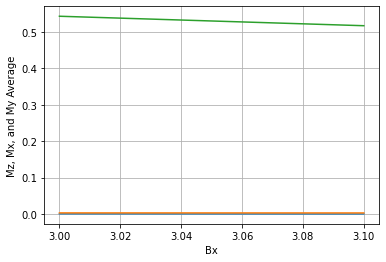

In [31]:
plt.cla()
plt.plot(Bx_arr, total_mz_arr[0])
plt.plot(Bx_arr, total_mx_arr[0])
plt.plot(Bx_arr, total_my_arr[0])
plt.grid()
plt.xlabel("Bx")
plt.ylabel("Mz, Mx, and My Average")
plt.show()

## b. Magnetization (Mz(t), Mx(t), My(t) vs Time (t))

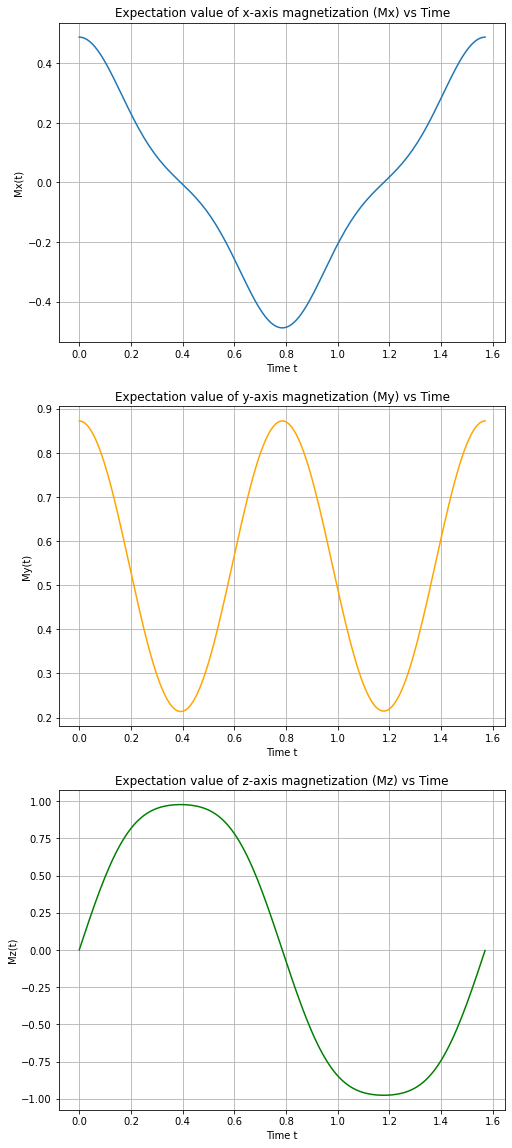

In [32]:
fig, (ax_x, ax_y, ax_z) = plt.subplots(nrows=3, ncols=1, figsize=(8, 20))

## The plot for Mx(t) vs Time t ##
ax_x.plot(tlist, mx_time_arr[0])
ax_x.set_title('Expectation value of x-axis magnetization (Mx) vs Time')
ax_x.set_xlabel("Time t")
ax_x.set_ylabel("Mx(t)")
ax_x.grid()

## The plot for My(t) vs Time t ##
ax_y.plot(tlist, my_time_arr[0], color = 'orange')
ax_y.set_title('Expectation value of y-axis magnetization (My) vs Time')
ax_y.set_xlabel("Time t")
ax_y.set_ylabel("My(t)")
ax_y.grid()

## The plot for Mz(t) vs Time t ##
ax_z.plot(tlist, mz_time_arr[0], color='green')
ax_z.set_title('Expectation value of z-axis magnetization (Mz) vs Time')
ax_z.set_xlabel("Time t")
ax_z.set_ylabel("Mz(t)")
ax_z.grid()



## c. Plotting the total magnitude expectation value of the magnetization as a function of time (checking whether it is normalized or not)

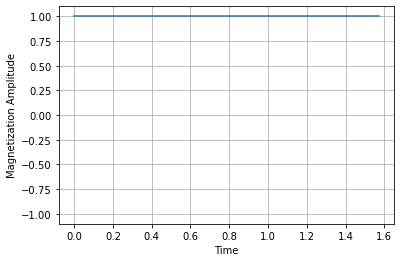

In [54]:
idx = np.where(Bx_arr == 3)
total_m = np.square(mx_time_arr[idx[0][0]])+np.square(my_time_arr[idx[0][0]])+np.square(mz_time_arr[idx[0][0]])
plt.ylim(-1.1, 1.1)
plt.xlabel("Time")
plt.ylabel("Magnetization Amplitude")
plt.grid()
plt.plot(tlist, total_m)

## d. Magnetization Squared vs Bx

In [ ]:
plt.plot()

# 5. 3D Projection and Bloch sphere visualization

## a. Functions needed for the projection

In [56]:
## Rotational matrices as functions ##
def z_axis_rot(angle, vector):
    rot_matrix = np.array([[np.cos(angle), -np.sin(angle), 0],
                           [np.sin(angle), np.cos(angle), 0],
                           [0, 0, 1]])
    
    new_vector = np.matmul(rot_matrix, vector)
    
    return new_vector;


def x_axis_rot(angle, vector):
    rot_matrix = np.array([[np.cos(angle), 0, np.sin(angle)],
                           [0, 1, 0],
                           [-np.sin(angle), 0, np.cos(angle)]])
    
    new_vector = np.matmul(rot_matrix, vector)
    
    return new_vector;
    
def y_axis_rot(angle, vector):
    rot_matrix = np.array([[1, 0, 0], 
                           [0, np.cos(angle), -np.sin(angle)], 
                           [0, np.sin(angle), np.cos(angle)]])
    
    new_vector = np.matmul(rot_matrix, vector)
    
    return new_vector;


## Indicating which quadrant is the magnetization vector is on (in 2D space) ##
def which_quadrant(x,y):
    quadrant = 0
    if(x>0 and y>0):
        quadrant = 1
        return int(quadrant)
    elif(x<0 and y>0):
        quadrant = 2
        return int(quadrant)
    elif(x<0 and y<0):
        quadrant = 3
        return int(quadrant)
    elif(x>0 and y<0):
        quadrant = 4
        return int(quadrant)
    

## b. The magnetization vector in the form of (Mz, Mx, My) and their spherical coordinates  

In [71]:
## Projection of the average Mx, My, Mz to a spherical coordinate ##
idx = np.where(Bx_arr == 3) # Give the index of a specific Bx value (in this case is Bx = 3.1)

p_radius = np.sqrt(np.square(total_mx_arr[0][idx[0][0]])+np.square(total_my_arr[0][idx[0][0]])
                   +np.square(total_mz_arr[0][idx[0][0]]))

p_theta = np.arctan(total_my_arr[0][idx[0][0]]/total_mx_arr[0][idx[0][0]])  # z-axis rotation

p_phi = np.arctan(np.sqrt(np.square(total_mx_arr[0][idx[0][0]])+np.square(total_my_arr[0][idx[0][0]]))
                  /total_mz_arr[0][idx[0][0]]) 

## Constructing the magnetization vector ##
M_array = []
for i in range(np.shape(mz_time_arr[idx[0][0]])[0]):
    M_vector = []
    M_vector.append((mx_time_arr[idx[0][0]])[i])
    M_vector.append((my_time_arr[idx[0][0]])[i])
    M_vector.append((mz_time_arr[idx[0][0]])[i])
    M_array.append(M_vector)

## c. Plotting the magnetization time-evolution on a Bloch sphere (3D Plot)

In [78]:
%matplotlib
plt.cla()
origin_point = [0,0,0]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

r = 0.05
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r, alpha=0.5)
plt.xlabel("Mx")
plt.ylabel("My")
ax.set_zlabel("Mz")

for i in range(np.shape(mz_time_arr[idx[0][0]])[0]): 

    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)
    ax.set_xlim(-1,1)
    ax.grid()
    ax.scatter3D(M_array[i][0], M_array[i][1],M_array[i][2], color = "green", s=0.5)
    
    plt.show()
     


Using matplotlib backend: MacOSX


## d. 2D Plotting (Stereographic Projection) and The Winding Number

In [287]:
%matplotlib

theta = np.linspace( 0 , 2 * np.pi , 150 )
radius = 10
 
    
a = radius * np.cos( theta )
b = radius * np.sin( theta )

a = 2*radius*a/(radius-0)
b = 2*radius*b/(radius-0)

 
figure_2d, axes_2d = plt.subplots( 1 )
 
axes_2d.cla()

plt.xlim(-1,1)
plt.ylim(-3,3)

plt.xlabel("Y")
plt.ylabel("Z")

prev_proj_theta = 0;
proj_theta_sum = 0;
proj_theta_arr = []
proj_rad_arr = []

angle_z = 0
angle_x = 0
angle_y = p_phi

X_arr = []
Y_arr = []

present_quadrant = 0
prev_quadrant = 0

q4_to_q1 = 0 # when q4_to_q1 = 1, it inidicates that the vector is going from quadrant 4 to quadrant 1



for i in range(np.shape(mz_time_val)[0]):
    new_vector = z_axis_rot(angle_z, M_array[i])
    new_vector = x_axis_rot(angle_x, new_vector)
    new_vector = y_axis_rot(angle_y, new_vector)

    x = new_vector[0]
    y = new_vector[1]
    z = new_vector[2]
    
    
    X = 2*radius*x/(radius-z)
    Y = 2*radius*y/(radius-z)
    
    
    X_arr.append(X)
    Y_arr.append(Y)
    

grad_X = np.gradient(X_arr)
grad_Y = np.gradient(Y_arr)
int_result = 0 


for i in range(np.shape(mz_time_val)[0]):
    
    proj_theta = np.degrees(np.arctan(Y_arr[i]/X_arr[i]))
    proj_rad = np.sqrt(X_arr[i]**2+Y_arr[i]**2)
    
    present_quadrant = which_quadrant(X_arr[i], Y_arr[i])
    
    if(present_quadrant != prev_quadrant):
        if(present_quadrant == 1 and prev_quadrant == 4):
            q4_to_q1 += 1
        elif(present_quadrant == 4 and prev_quadrant == 1):
            q4_to_q1 -= 1
        
    if(q4_to_q1 != 0):
        proj_theta = (q4_to_q1*360)+proj_theta
        
    if(Y_arr[i] > 0 and X_arr[i]<0):
        proj_theta = 180+proj_theta
        
    elif(Y_arr[i]<0 and X_arr[i]<0):
        proj_theta = 180+proj_theta
        
    elif(Y_arr[i]<0 and X_arr[i]>0):
        proj_theta = 360+proj_theta
        
    proj_theta_arr.append(proj_theta)
    proj_rad_arr.append(proj_rad)
    
    
    
    if(i==0):
        proj_theta_diff = 0
    else:
        proj_theta_diff = (proj_theta-prev_proj_theta)
        
        
    proj_theta_sum += proj_theta_diff
    print("this is number of windings per time:", proj_theta_sum/360, "This is the theta:",proj_theta)
    print("This is the difference:",proj_theta_diff)
    print()

    prev_proj_theta = proj_theta
    prev_quadrant = present_quadrant
    

    axes_2d.scatter(0,0,color="blue",s=0.5)
    axes_2d.scatter(X_arr[i],Y_arr[i], color = "green", s=0.5)
    #plt.pause(1)
    
    
    plt.show()
    
n_of_windings = proj_theta_sum/(360)
print(n_of_windings)


Using matplotlib backend: MacOSX
this is number of windings per time: 0.0 This is the theta: 179.16465914330857
This is the difference: 0

this is number of windings per time: 0.16858184918649247 This is the theta: 239.85412485044586
This is the difference: 60.68946570713729

this is number of windings per time: 0.20204444232692798 This is the theta: 251.90065838100264
This is the difference: 12.046533530556786

this is number of windings per time: 0.2124057526840478 This is the theta: 255.63073010956577
This is the difference: 3.730071728563132

this is number of windings per time: 0.21628882242251682 This is the theta: 257.0286352154146
This is the difference: 1.3979051058488494

this is number of windings per time: 0.2178497916287868 This is the theta: 257.5905841296718
This is the difference: 0.5619489142571865

this is number of windings per time: 0.2183887773454121 This is the theta: 257.7846189876569
This is the difference: 0.1940348579851161

this is number of windings per time

this is number of windings per time: -0.7829630828560702 This is the theta: -102.70205068487667
This is the difference: -0.3047870335898324

this is number of windings per time: -0.7836371273816701 This is the theta: -102.94470671409266
This is the difference: -0.24265602921599339

this is number of windings per time: -0.7841260015194939 This is the theta: -103.12070140370918
This is the difference: -0.1759946896165161

this is number of windings per time: -0.7844353587197953 This is the theta: -103.23206999581771
This is the difference: -0.11136859210853345

this is number of windings per time: -0.7845737751833551 This is the theta: -103.28189992269927
This is the difference: -0.049829926881557185

this is number of windings per time: -0.7845776417942956 This is the theta: -103.28329190263781
This is the difference: -0.0013919799385462284

this is number of windings per time: -0.784526367495845 This is the theta: -103.26483315519562
This is the difference: 0.018458747442196

this is n

In [ ]:
theta = np.linspace( 0 , 2 * np.pi , 150 )
radius = 1
vector_pos = []
for i in range(len(theta)):
    temp_vector = []
    a_test = radius*np.cos(theta[i])
    b_test = radius*np.sin(theta[i])
    temp_vector.append(0)
    temp_vector.append(a_test)
    temp_vector.append(b_test)
    vector_pos.append(temp_vector)

## USING TOTAL CURVATURE

In [25]:
tang_vect_arr = [] 
for i in range((np.shape(mz_time_val)[0])-1):
    tang_vect = (np.array(M_array[i+1])-np.array(M_array[i]))/tstep
    tang_vect = tang_vect/np.linalg.norm(tang_vect)
    tang_vect_arr.append(tang_vect) # Here we got T = dr/dt (MUST BE NORMALIZED)
    
diff_tang_vect_arr = []
for i in range(len(tang_vect_arr)-1):
    diff_tang_vect = np.array(tang_vect_arr[i+1])-np.array(tang_vect_arr[i])
    diff_tang_vect_arr.append(diff_tang_vect)

    
angle_z = p_theta
angle_x = p_phi
angle_y = 0   
      
X_arr = []
Y_arr = []

radius = 1

for i in range(np.shape(mz_time_val)[0]):
    new_vector = z_axis_rot(angle_z, M_array[i])
    new_vector = x_axis_rot(angle_x, new_vector)
    new_vector = y_axis_rot(angle_y, new_vector)

    x = new_vector[0]
    y = new_vector[1]
    z = new_vector[2]
    
    
    X = 2*radius*x/(radius-z)
    Y = 2*radius*y/(radius-z)
    
    
    X_arr.append(X)
    Y_arr.append(Y)

    
arc_length = []
for i in range(len(mz_time_val)-1):
    diff_X = X_arr[i+1]-X_arr[i]
    diff_Y = Y_arr[i+1]-Y_arr[i]
    arc_length_single = np.sqrt((diff_X**2)+ (diff_Y**2))
    arc_length.append(arc_length)
    
    

In [71]:
result = 0
for i in range(len(diff_tang_vect_arr)):
    kappa = (np.linalg.norm(diff_tang_vect_arr[i]))
    result += kappa
    
print(result)   

32.74312457243268


In [72]:
result/(2*np.pi)

5.211230127976362

7.5008762409878535


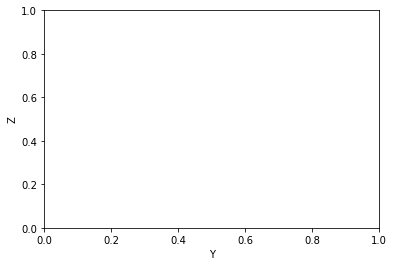

In [94]:
## FOR THE CURVATURE ONE BUT PROJECTED ##

theta = np.linspace( 0 , 2 * np.pi , 150 )
radius = 1
 
a = radius * np.cos( theta )
b = radius * np.sin( theta )

a = 2*radius*a/(radius-0)
b = 2*radius*b/(radius-0)



figure_2d, axes_2d = plt.subplots( 1 )

#axes_2d.cla()
#axes_2d.plot( a, b )

#axes_2d.set_aspect( 1 )
# plt.xlim(-3,3)
# plt.ylim(-3,3)

plt.xlabel("Y")
plt.ylabel("Z")

prev_proj_theta = 0;
proj_theta_sum = 0;
proj_theta_arr = []
proj_rad_arr = []

angle_z = p_theta
angle_x = p_phi
angle_y = 0

X_arr = []
Y_arr = []

present_quadrant = 0
prev_quadrant = 0

q4_to_q1 = 0


for i in range(np.shape(mz_time_val)[0]):
    new_vector = z_axis_rot(angle_z, M_array[i])
    new_vector = x_axis_rot(angle_x, new_vector)
    new_vector = y_axis_rot(angle_y, new_vector)

    x = new_vector[0]
    y = new_vector[1]
    z = new_vector[2]
    
    
    X = 2*radius*x/(radius-z)
    Y = 2*radius*y/(radius-z)
    
    
    X_arr.append(X)
    Y_arr.append(Y)


grad_X = np.gradient(X_arr)
grad_Y = np.gradient(Y_arr)
int_result = 0 

tang_vect_arr_2D = [] 

for i in range((np.shape(mz_time_val)[0])-1):
    diff_X = X_arr[i+1]-X_arr[i]
    diff_Y = Y_arr[i+1]-Y_arr[i]
    
    diff_vect = [diff_X, diff_Y];
    
    tang_vect = np.array(diff_vect)/tstep
    tang_vect = tang_vect/np.linalg.norm(tang_vect)
    tang_vect_arr_2D.append(tang_vect) # Here we got T = dr/dt (MUST BE NORMALIZED)
    
        
        
arc_length = []
for i in range(len(mz_time_val)-1):
    diff_X = X_arr[i+1]-X_arr[i]
    diff_Y = Y_arr[i+1]-Y_arr[i]
    arc_length_single = np.sqrt((diff_X**2)+ (diff_Y**2))
    arc_length.append(arc_length_single)
    
avg_arc_length = []
for i in range(len(arc_length)-1):
    avg_arc = (arc_length[i+1]+arc_length[i])/2
    avg_arc_length.append(avg_arc)
    
    
diff_tang_vect_arr_2D = []
for i in range(len(tang_vect_arr_2D)-1):
    diff_tang_vect = (np.array(tang_vect_arr_2D[i+1])-np.array(tang_vect_arr_2D[i]))/avg_arc_length[i]
    diff_tang_vect_arr_2D.append(diff_tang_vect)
    
    
    
result_2D = 0
for i in range(len(diff_tang_vect_arr_2D)):
    kappa = (np.linalg.norm(diff_tang_vect_arr_2D[i]))*arc_length[i]
    result_2D += kappa
    
    

print(result_2D/(2*np.pi)) 


#derivative_theta = np.gradient(np.arctan(Y_arr/X_arr))

# for i in range(np.shape(mz_time_val)[0]):
# #for i in range(len(theta)):

    

# #     angle_z = 0
# #     angle_x = np.pi/2
# #     angle_y = 0
    
# #     new_vector = z_axis_rot(angle_z, M_array[i])
# #     new_vector = x_axis_rot(angle_x, new_vector)p
# #     x = new_vector[0]
# #     y = new_vector[1]
# #     z = new_vector[2]
    
    
# #     X = 2*radius*x/(radius-z)
# #     Y = 2*radius*y/(radius-z)


# #     int_sum_1 = (-Y_arr[i]/(X_arr[i]**2 + Y_arr[i]**2))*grad_X[i]*tstep
# #     int_sum_2 = (X_arr[i]/(X_arr[i]**2 + Y_arr[i]**2))*grad_Y[i]*tstep
# #     int_result = int_result+int_sum_1+int_sum_2

    
# #     int_result += (derivative_theta[i]*tsteps)
    
#     proj_theta = np.degrees(np.arctan(Y_arr[i]/X_arr[i]))
#     proj_rad = np.sqrt(X_arr[i]**2+Y_arr[i]**2)
    
#     present_quadrant = which_quadrant(X_arr[i], Y_arr[i])
    
#     if(present_quadrant != prev_quadrant):
#         if(present_quadrant == 1 and prev_quadrant == 4):
#             q4_to_q1 += 1
#         elif(present_quadrant == 4 and prev_quadrant == 1):
#             q4_to_q1 -= 1
        
    
#     if(q4_to_q1 != 0):
#         proj_theta = (q4_to_q1*360)+proj_theta
        
        
#     if(Y_arr[i] > 0 and X_arr[i]<0):
#         proj_theta = 180+proj_theta
        
#     elif(Y_arr[i]<0 and X_arr[i]<0):
#         proj_theta = 180+proj_theta
        
#     elif(Y_arr[i]<0 and X_arr[i]>0):
#         proj_theta = 360+proj_theta
        
#     proj_theta_arr.append(proj_theta)
#     proj_rad_arr.append(proj_rad)
    
    
    
#     if(i==0):
#         proj_theta_diff = 0
#     else:
#         proj_theta_diff = (proj_theta-prev_proj_theta)
        
        
#     proj_theta_sum += proj_theta_diff
#     print("this is number of windings per time:", proj_theta_sum/360, "This is the theta:",proj_theta)
#     print("This is the difference:",proj_theta_diff)
#     print()
#     #if(proj_theta_sum/360)
#     prev_proj_theta = proj_theta
#     prev_quadrant = present_quadrant
    
    
#     #proj_radius = np.sqrt(X**2+Y**2)
# #     windings_per_time = proj_theta_sum/360;
# #     if(np.absolute(np.abs(windings_per_time) - 1) < 0.0008):
# #         if(windings_per_time<0):
# #             negative_wind+=1;
# #         else:
# #             positive_wind+=1;
    
#     axes_2d.scatter(0,0,color="blue",s=0.5)
#     axes_2d.scatter(X_arr[i],Y_arr[i], color = "green", s=0.5)
#     #plt.pause(0.1)
    
    
#     plt.show()
    
# n_of_windings = proj_theta_sum/(360)
# print(n_of_windings)
# # print(negative_wind)
# # print(positive_wind)

0.9932149967153124


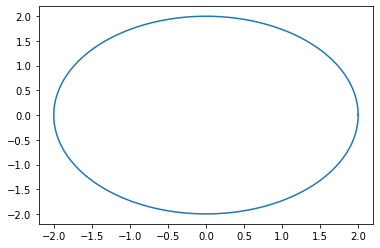

In [37]:
## FOR THE CURVATURE ONE BUT PROJECTED (FOR CIRCLE!!) ##

theta = np.linspace( 0 , 2 * np.pi , 150 )
radius = 1
 
a = radius * np.cos( theta )
b = radius * np.sin( theta )

a = 2*radius*a/(radius-0)
b = 2*radius*b/(radius-0)


figure_2d, axes_2d = plt.subplots( 1 )

axes_2d.cla()
axes_2d.plot( a, b )


angle_z = p_theta
angle_x = p_phi
angle_y = 0

X_arr = []
Y_arr = []

present_quadrant = 0
prev_quadrant = 0

q4_to_q1 = 0



tang_vect_arr_2D = [] 
arc_length = []
for i in range(len(theta)-1):
    diff_X = a[i+1]-a[i]
    diff_Y = b[i+1]-b[i]
    
    diff_vect = [diff_X, diff_Y];
    
    tang_vect = np.array(diff_vect)/0.042
    tang_vect = tang_vect/np.linalg.norm(tang_vect)
    tang_vect_arr_2D.append(tang_vect) # Here we got T = dr/dt (MUST BE NORMALIZED)
    
    arc_length_single = np.sqrt((diff_X**2)+ (diff_Y**2))
    arc_length.append(arc_length_single)
    
        
    
    
diff_tang_vect_arr_2D = []
for i in range(len(tang_vect_arr_2D)-1):
    diff_tang_vect = (np.array(tang_vect_arr_2D[i+1])-np.array(tang_vect_arr_2D[i]))/arc_length[i]
    diff_tang_vect_arr_2D.append(diff_tang_vect)
    
  
    
result_2D = 0
for i in range(len(diff_tang_vect_arr_2D)):
    kappa = (np.linalg.norm(diff_tang_vect_arr_2D[i]))*arc_length[i]
    result_2D += kappa
    
    

print(result_2D/(2*np.pi)) 



    